In [3]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.proba.banana2d import Banana2D
from mcjax.mcmc.mala import Mala
from mcjax.util.mcmc import ESS_geyer, normalized_autocorr



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# initialize jax RNG
key = jr.key(0)

### 2D Banana

In [5]:
# create an isotropic Gaussian
dist = Banana2D(noise_std = 0.3)

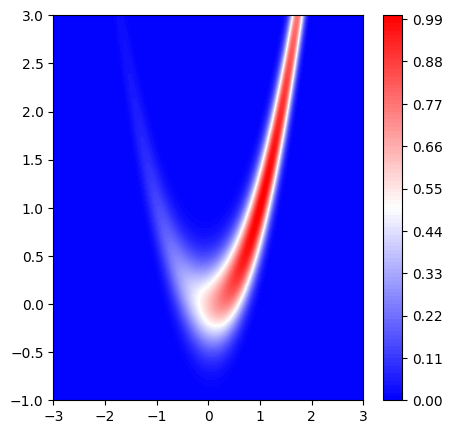

In [6]:
xmin, xmax = -3, 3
ymin, ymax = -1, 3
N_discr = 300
X, Y = np.meshgrid(np.linspace(xmin, xmax, N_discr), np.linspace(ymin, ymax, N_discr), indexing='ij')
X_flat = X.ravel()
Y_flat = Y.ravel()
Z_flat = dist.batch(jnp.array([X_flat, Y_flat]).T)
Z = Z_flat.reshape(X.shape)

# plot the logpdf
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.colorbar()
plt.show()


## Run Mala

In [7]:
mcmc = Mala(logdensity=dist, epsilon=0.01)

(-1.0, 3.0)

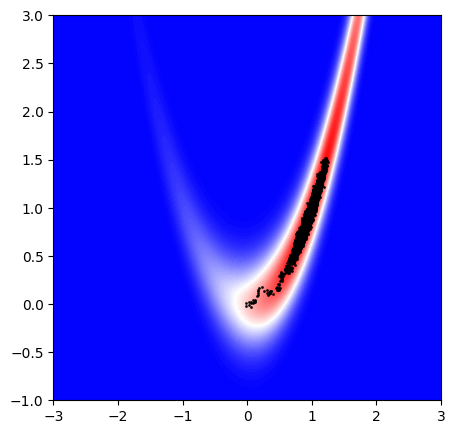

In [8]:
key, key_ = jr.split(key)
x_init = jnp.array([0., 0.])
state_init = mcmc.init_state(x_init)
mcmc_output = mcmc.run(key = key_, n_samples=10_000, state_init=state_init)
samples = mcmc_output["x"]
# scatter plot of the samples
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.scatter(samples[:, 0], samples[:, 1], s=1, color='black', alpha=0.9)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

In [9]:
print(mcmc_output['acceptance_rate'])

0.99803144


## Influence of epsilon on the acceptance rate

In [10]:
# let's define a function that samples a trajectory -- small wrapper around the `sample_RWM` function
def sample_MALA(key, x0, epsilon, n_steps):
    # define the RWM sampler
    mcmc = Mala(logdensity=dist, epsilon=epsilon)
    # sample the trajectory
    state_init = mcmc.init_state(x0)
    mcmc_output = mcmc.run(key = key, n_samples=n_steps, state_init=state_init)
    return mcmc_output

sample_MALA = jax.jit(sample_MALA, static_argnums=(3,))

# let's define a function that samples a batch of trajectories
# for different step sizes so that we can study the influence of the step size
sample_MALA_batch = jax.vmap(sample_MALA, in_axes=(None, None, 0, None))
sample_MALA_batch = jax.jit(sample_MALA_batch, static_argnums=(3,))

In [11]:
epsilon_arr = np.linspace(0.001, 0.1, 100)
n_steps = 100_000
key, key_ = jr.split(key)
x0 = jnp.array([0., 0.])
mcmc_output_batch = sample_MALA_batch(key_, x0, epsilon_arr, n_steps)

0.001


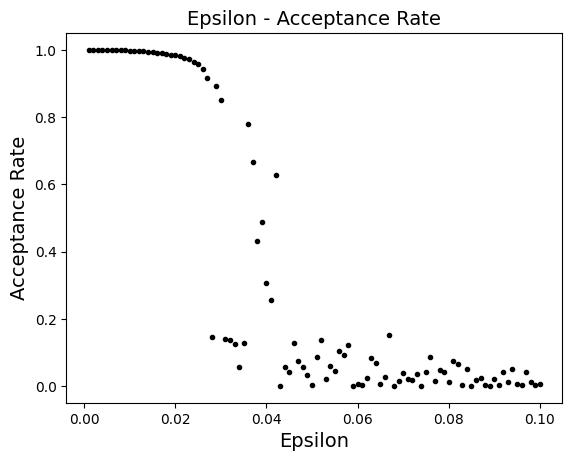

In [12]:
plt.plot(epsilon_arr, mcmc_output_batch["acceptance_rate"], ".", color='black')
plt.xlabel("Epsilon", fontsize=14)
plt.ylabel("Acceptance Rate", fontsize=14)
plt.title("Epsilon - Acceptance Rate", fontsize=14)
print(epsilon_arr[np.argmax(mcmc_output_batch["acceptance_rate"])])



## Maximize effective sample size

Text(0, 0.5, 'Effective Sample Size')

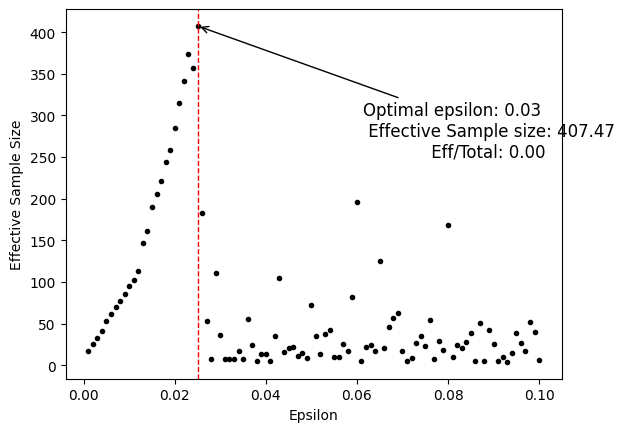

In [13]:
ess_geyer_list = [ESS_geyer(mcmc_output_batch["x"][k,:,0]) for k in range(len(epsilon_arr))]
plt.plot(epsilon_arr,ess_geyer_list,'.',color='black')
optimal_epsilon = epsilon_arr[np.argmax(ess_geyer_list)]
plt.axvline(optimal_epsilon, color='red', lw=1, ls='--')
# add an arrow pointing to the optimal step size with the value
plt.annotate(f"Optimal epsilon: {optimal_epsilon:.2f} \n Effective Sample size: {np.max(ess_geyer_list):.2f} \n\
             Eff/Total: {np.max(ess_geyer_list)/n_steps:.2f}",
                xy=(optimal_epsilon, np.max(ess_geyer_list)),
                xytext=(0.6, 0.6),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='red', arrowstyle="->"),
                fontsize=12)
plt.xlabel("Epsilon")
plt.ylabel("Effective Sample Size")